# Kaiserslautern Bikesharing Rental Analysis

Introduction to Data Science and Machine Learning        XIA Mingxiang_7374120

### Load functional package and read data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import math

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=DeprecationWarning)

from datetime import date, time, datetime, timedelta
from dateutil import parser

%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\admin\Desktop\Kaiserslautern.csv')
hourdf = pd.read_csv(r'C:\Users\admin\Desktop\Kaiserslautern_rental amount in hours.csv')
bike_utilization = pd.read_csv(r'C:\Users\admin\Desktop\Kaiserslautern_bike utilization.csv')

In [3]:
df.head()

,day,year,month,weekday,is_weekend,is_holiday,season,time,hour,b_number,...,trip_duration,price,orig_lat,orig_lng,dest_lat,dest_lng,temperature,precipitation,humidity,vapor_pressure
0,2019/1/20,2019,1,7,1,0,4,15:19:00,15,43702,...,7,1.0,49.443056,7.759164,49.436519,7.769024,-4.8,0.0,90.83,3.9
1,2019/1/20,2019,1,7,1,0,4,16:06:00,16,43702,...,11,1.0,49.436519,7.769024,49.446787,7.758644,-4.8,0.0,90.83,3.9
2,2019/1/20,2019,1,7,1,0,4,8:12:00,8,43713,...,8,1.0,49.444084,7.772377,49.436519,7.769024,-4.8,0.0,90.83,3.9
3,2019/1/20,2019,1,7,1,0,4,13:01:00,13,43713,...,5,1.0,49.436519,7.769024,49.443052,7.770864,-4.8,0.0,90.83,3.9
4,2019/1/20,2019,1,7,1,0,4,23:32:00,23,43713,...,22,1.0,49.443052,7.770864,49.438643,7.763203,-4.8,0.0,90.83,3.9


### Data preprocessing

In [4]:
df['day']=pd.to_datetime(df['day'])
df.info()
# Reset the Dtype of 'day' column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45783 entries, 0 to 45782
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   day             45783 non-null  datetime64[ns]
 1   year            45783 non-null  int64         
 2   month           45783 non-null  int64         
 3   weekday         45783 non-null  int64         
 4   is_weekend      45783 non-null  int64         
 5   is_holiday      45783 non-null  int64         
 6   season          45783 non-null  int64         
 7   time            45783 non-null  object        
 8   hour            45783 non-null  int64         
 9   b_number        45783 non-null  int64         
 10  city            45783 non-null  object        
 11  trip_duration   45783 non-null  int64         
 12  price           45783 non-null  float64       
 13  orig_lat        45783 non-null  float64       
 14  orig_lng        45783 non-null  float64       
 15  de

**Indicator Description:**  
- day: date in the form of yyyy/mm/dd
- year
- month
- weekday: 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Friday, 6 = Saturday, 7 = Sunday
- is_weekend: 1 = weekend, 0 = working day
- is_holiday: 1 = holiday, 0 = non-holiday, including weekend if holidays are next to weekend, in order to better simulate the reallife traveling situation of citizens
- season: 1 = Spring, 2 = Summer, 3 = Autumn, 4 = Winter
- temperature: mean temperature at 2m above ground in ºC
- humidity: mean of relative humidity at 2m above ground in %
- vapor_pressure: mean vapor pressure in hpa
- precipitation: precipitation height in mm

**Research Question:**
- What is the relationship between the rental amount of bikes and these above indicators? What is the trend?
- Forecast the demand of shared bikes through these features in the test cluster.

In [5]:
df.describe()

# No missing value
# Standard deviations of all features are within a reasonable range, without a large number of obvious anomalous values.

,year,month,weekday,is_weekend,is_holiday,season,hour,b_number,trip_duration,price,orig_lat,orig_lng,dest_lat,dest_lng,temperature,precipitation,humidity,vapor_pressure
count,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000,45783.000000
mean,2019.040211,6.882227,3.826944,0.239084,0.030929,2.351659,13.574930,108837.773737,15.055283,1.197988,49.436904,7.762779,49.437126,7.762955,12.955909,1.445071,74.390518,11.081019
std,0.196457,3.007043,1.926990,0.426529,0.173126,1.003557,5.332238,144353.451471,18.691811,0.872040,0.007543,0.011006,0.007554,0.011020,6.825089,3.101381,13.824209,3.730912
min,2019.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,42737.000000,3.000000,1.000000,49.396418,7.653362,49.396680,7.656418,-5.300000,0.000000,40.750000,3.300000
25%,2019.000000,5.000000,2.000000,0.000000,0.000000,2.000000,10.000000,43760.000000,7.000000,1.000000,49.430752,7.752914,49.430752,7.752914,7.800000,0.000000,63.500000,7.900000
50%,2019.000000,7.000000,4.000000,0.000000,0.000000,2.000000,14.000000,43829.000000,10.000000,1.000000,49.436519,7.763203,49.438643,7.763203,13.300000,0.000000,74.210000,11.000000
75%,2019.000000,9.000000,5.000000,0.000000,0.000000,3.000000,18.000000,44451.000000,15.000000,1.000000,49.443056,7.769024,49.443056,7.769024,17.800000,1.100000,87.500000,14.200000
max,2020.000000,12.000000,7.000000,1.000000,1.000000,4.000000,23.000000,430397.000000,179.000000,8.500000,49.491858,7.861331,49.554467,7.861304,28.800000,24.200000,100.000000,21.400000


### Observe the overall trend

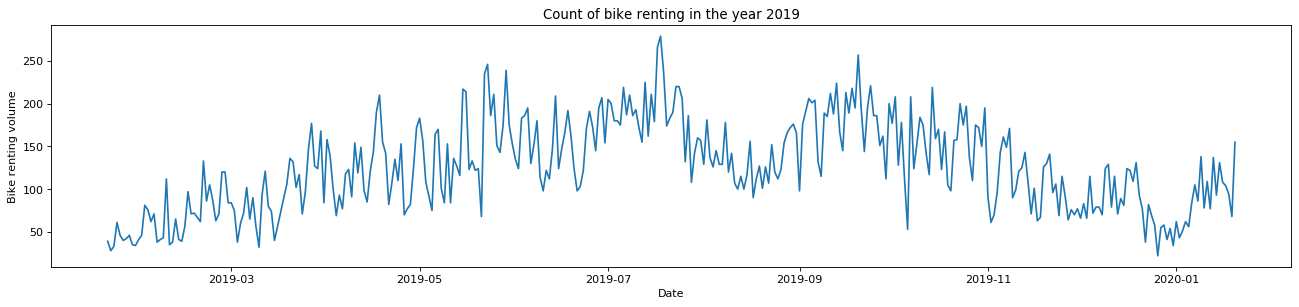

In [6]:
bike_volume_by_date = df.groupby('day')['day'].count()

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)

ax.plot(bike_volume_by_date)
ax.set_xlabel('Date')
ax.set_ylabel("Bike renting volume")
ax.set_title('Count of bike renting in the year 2019')

plt.show()

# Distribution of the amount of bike-sharing rentals in the given period

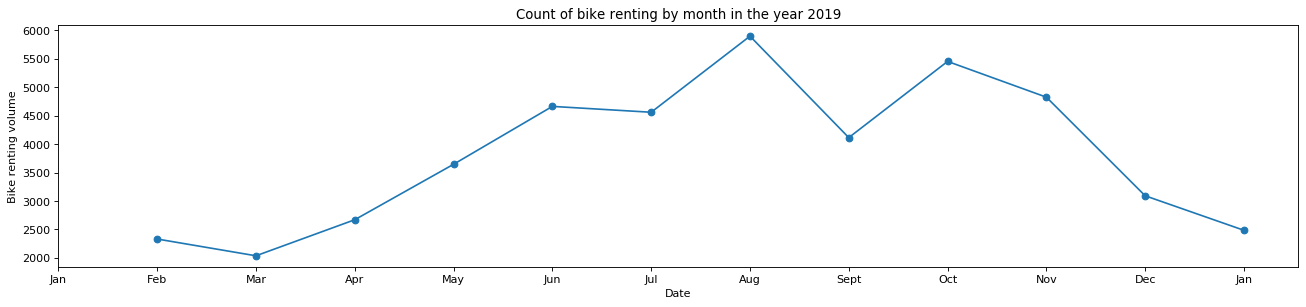

In [7]:
bike_volume_by_month = df.groupby('month')['month'].count()

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)

ax.plot(bike_volume_by_month,'o-')
ax.set_xlabel('Date')
ax.set_ylabel("Bike renting volume")
ax.set_xticks(list(range(13)))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Jan'])
ax.set_title('Count of bike renting by month in the year 2019')

plt.show()

# Create a line chart indicating monthly bike rental situation in the given period

Comparing the above two graphs about the annual change of bike rental volume:  
- The rental status of shared bikes basically increased from January to July, while fluctuatedly declined from August to December.
- The number of bike rentals has been growing from January to July, and reached peak of this period at the end of July.
- There was a significant decline from July to August, presumably due to high outdoor temperatures in summer.
- Bike rentals stabilized in Kaiserslautern from August to October, while it dropped from October to December. The annual minimum rental volume appeared around the Christmas and New Year holidays.

In [8]:
df_hour_count = df.groupby('hour')['day'].count().reset_index('hour')
df_hour_count.rename(columns={'day':'count of hour'},inplace=True)
df_hour_count

,hour,count of hour
0,0,557
1,1,404
2,2,329
3,3,393
4,4,509
5,5,1107
6,6,1968
7,7,1833
8,8,1895
9,9,2001


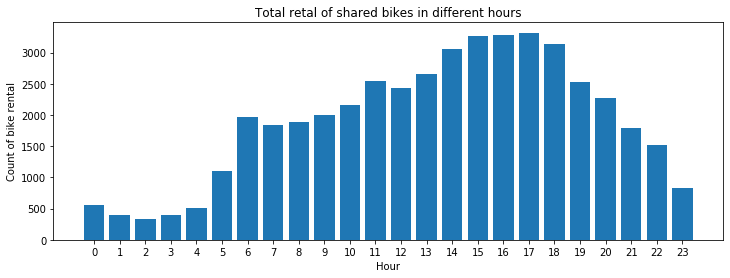

In [9]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
fig.set_size_inches(12,4)

plt.bar(df_hour_count['hour'], df_hour_count['count of hour'])
plt.title('Total retal of shared bikes in different hours',fontsize=12)
plt.xlabel('Hour')
plt.ylabel('Count of bike rental')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

plt.show()

# Bikes are used more during off-duty hours than during office hours. 
# In the afternoon, bikes should better be appropriately transported to business areas and with high demand for bikes.

### Treatment of weather-related indicator outliers

Text(0.5, 1.0, 'Distribution of vapor_pressure')

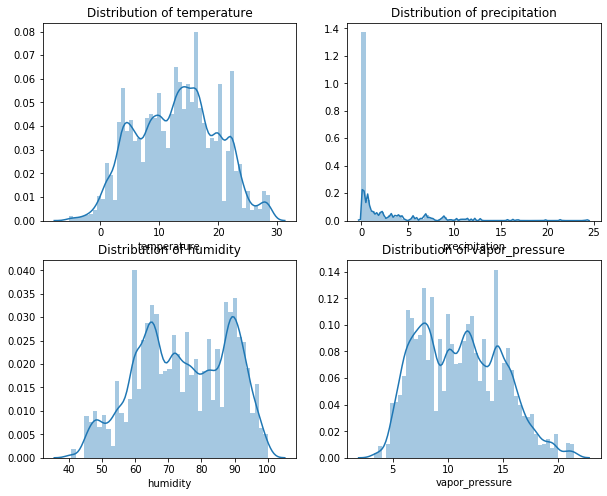

In [10]:
fig=plt.figure()
fig.set_size_inches(10,8)

ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

sns.distplot(df['temperature'],ax=ax1)
sns.distplot(df['precipitation'],ax=ax2)
sns.distplot(df['humidity'],ax=ax3)
sns.distplot(df['vapor_pressure'],ax=ax4)

ax1.set_title('Distribution of temperature')
ax2.set_title('Distribution of precipitation')
ax3.set_title('Distribution of humidity')
ax4.set_title('Distribution of vapor_pressure')

# Create displots to check weather data for outliers.
# Have a general picture of the distribution of different variables, and then generate frequency tables for them.
# Draw histograms for each numerical variable.

In [11]:
# It is observed that precipitation are greatly concentrated in  0, most of them are in 0-1 mm. 
# My initial assumption is that the missing value might be replaced with 0 instead of being left.
# Such data, even if true, will have a great impact on the prediction in the later period.
# Therefore, it is necessary to predict and fill the precipitation by using relevant machine learning methods.
# Using relevant data such as month, season, temperature, humidity, precipitation could be estimated and filled by Random forest regressor.

# Divide the data into precipitation equal to and not equal to 0
Datapre0=df[df['precipitation']==0]
DatapreN0=df[df['precipitation']!=0]

# Pick out relevant features for predicting
FeaturesCol=['year','month','season','temperature','humidity','vapor_pressure']

# Choose Random forest regressor for modeling
model_precipitation=RandomForestRegressor(n_estimators=100, random_state=42)

# Set the data which precipitation are not equal to 0 as training data
model_precipitation.fit(DatapreN0[FeaturesCol],DatapreN0['precipitation'])

# Establish a model based on training data to predict
PreValues=model_precipitation.predict(X=Datapre0[FeaturesCol])

# Replace precipitation outliers with predicted values
Datapre0['precipitation']=PreValues

# Merge two data sets
df=Datapre0.append(DatapreN0,ignore_index=True)
df.head()

,day,year,month,weekday,is_weekend,is_holiday,season,time,hour,b_number,...,trip_duration,price,orig_lat,orig_lng,dest_lat,dest_lng,temperature,precipitation,humidity,vapor_pressure
0,2019-01-20,2019,1,7,1,0,4,15:19:00,15,43702,...,7,1.0,49.443056,7.759164,49.436519,7.769024,-4.8,2.574,90.83,3.9
1,2019-01-20,2019,1,7,1,0,4,16:06:00,16,43702,...,11,1.0,49.436519,7.769024,49.446787,7.758644,-4.8,2.574,90.83,3.9
2,2019-01-20,2019,1,7,1,0,4,8:12:00,8,43713,...,8,1.0,49.444084,7.772377,49.436519,7.769024,-4.8,2.574,90.83,3.9
3,2019-01-20,2019,1,7,1,0,4,13:01:00,13,43713,...,5,1.0,49.436519,7.769024,49.443052,7.770864,-4.8,2.574,90.83,3.9
4,2019-01-20,2019,1,7,1,0,4,23:32:00,23,43713,...,22,1.0,49.443052,7.770864,49.438643,7.763203,-4.8,2.574,90.83,3.9


Text(0.5, 1.0, 'Distribution of vapor_pressure')

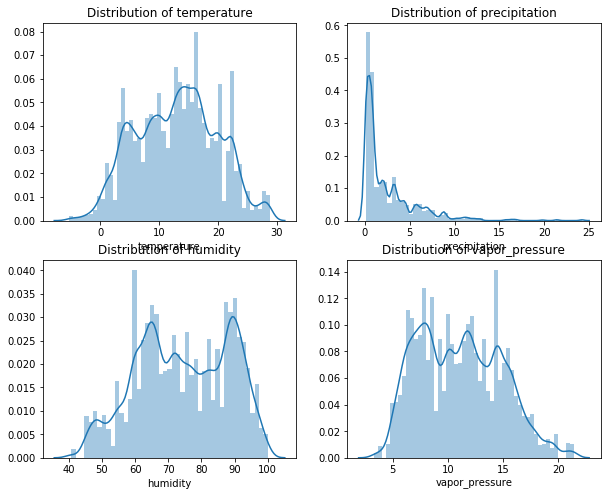

In [12]:
# Visualize the Dateframe after filling with predicted values, and observe the value distribution

fig=plt.figure()
fig.set_size_inches(10,8)

ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,2,3)
ax4=fig.add_subplot(2,2,4)

sns.distplot(df['temperature'],ax=ax1)
sns.distplot(df['precipitation'],ax=ax2)
sns.distplot(df['humidity'],ax=ax3)
sns.distplot(df['vapor_pressure'],ax=ax4)

ax1.set_title('Distribution of temperature')
ax2.set_title('Distribution of precipitation')
ax3.set_title('Distribution of humidity')
ax4.set_title('Distribution of vapor_pressure')

# Under the observation of the following graphs, the precipitation anomaly value was successfully replaced.

### Observe the rental density distribution

In [13]:
df_count = df.groupby(['day'])['day'].count().reset_index(name='count')
df_count = pd.merge(df_count,df,on='day',how='outer') 

df_count = df_count.drop_duplicates(['day'])
df_count = df_count.reset_index(drop=True)

df_count.drop(['time','hour','b_number','trip_duration','orig_lat','orig_lng','dest_lat','dest_lng','price'], axis=1,inplace=True)

df_price = df.groupby(['day'])['price'].sum().reset_index(name='price')
df_count = pd.merge(df_price,df_count,on='day',how='inner')

df_count

,day,price,count,year,month,weekday,is_weekend,is_holiday,season,city,temperature,precipitation,humidity,vapor_pressure
0,2019-01-20,39.0,39,2019,1,7,1,0,4,kaiserslautern,-4.8,2.574,90.83,3.9
1,2019-01-21,29.5,28,2019,1,1,0,0,4,kaiserslautern,-5.3,3.212,88.50,3.7
2,2019-01-22,33.0,33,2019,1,2,0,0,4,kaiserslautern,-4.3,1.100,87.46,3.9
3,2019-01-23,82.0,61,2019,1,3,0,0,4,kaiserslautern,-2.8,0.700,87.50,4.4
4,2019-01-24,46.0,46,2019,1,4,0,0,4,kaiserslautern,-3.3,0.100,80.33,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2020-01-16,118.5,108,2020,1,4,0,0,4,kaiserslautern,8.8,1.747,78.17,8.8
359,2020-01-17,105.5,104,2020,1,5,0,0,4,kaiserslautern,5.4,0.200,89.17,8.1
360,2020-01-18,112.0,94,2020,1,6,1,0,4,kaiserslautern,3.5,0.400,87.79,6.9
361,2020-01-19,72.5,68,2020,1,7,1,0,4,kaiserslautern,1.5,0.100,92.50,6.3


Text(0.5, 1.0, 'Distribution of count')

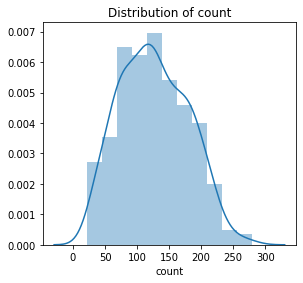

In [14]:
fig=plt.figure()
ax8=fig.add_subplot(2,2,1)
fig.set_size_inches(10,9)
sns.distplot(df_count['count'],ax=ax8)
ax8.set_title('Distribution of count')

# Observe the distribution of bike rentals to understand the difference in data.
# In order to improve the accuracy of prediction and analysis in the later stage, the data should normally distributed as far as possible.
# The count distribution in the following chart basically conforms to the required normal distribution principle.

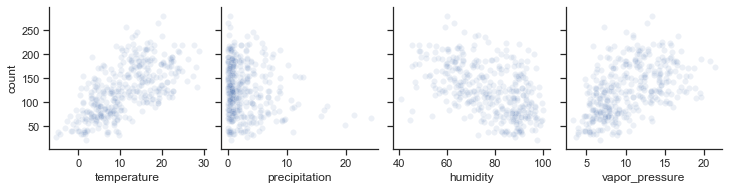

In [15]:
sns.set(style='ticks',color_codes=True)
sns.pairplot(df_count,x_vars=['temperature','precipitation','humidity','vapor_pressure'],
            y_vars=['count'],plot_kws={'alpha':0.1})

### Correlation analysis between features and rental amount

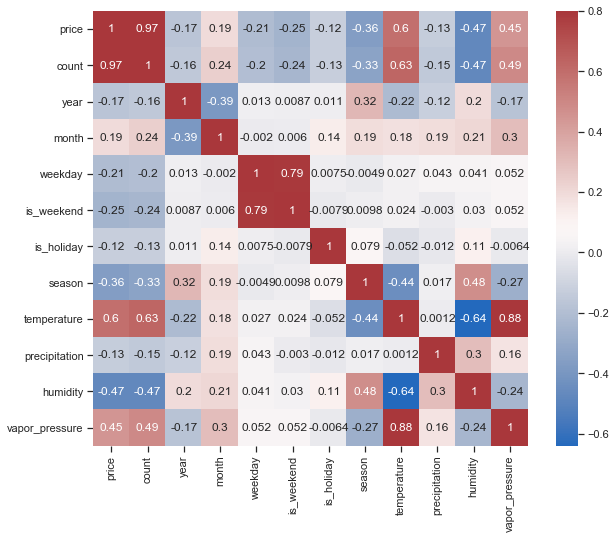

In [16]:
corrmat = df_count.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, vmax=.8, square=True,linecolor='white',annot=True,cmap='vlag')

plt.show()

In [17]:
correlation_mat=df_count.corr()
correlation_mat["count"].sort_values(ascending=False)

# The correlation can be concluded as：
# Positive correlation: temperature>vapor_pressure>month
# Negative correlation: humidity>season>is_weekend>weekday>year>precipitation>is_holiday

count             1.000000
price             0.971385
temperature       0.629702
vapor_pressure    0.491054
month             0.237463
is_holiday       -0.125157
precipitation    -0.146672
year             -0.156352
weekday          -0.200778
is_weekend       -0.237439
season           -0.333868
humidity         -0.472510
Name: count, dtype: float64

### The effect of temperature on rental amount

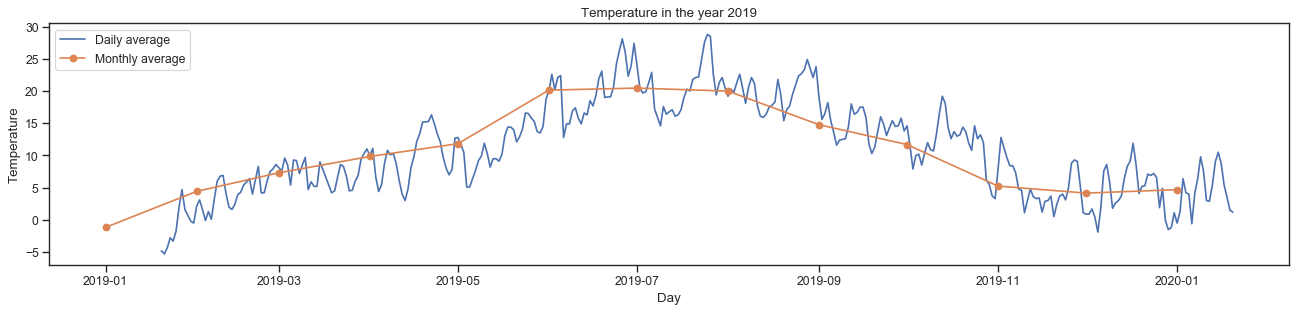

In [18]:
temperaturedf = df_count.groupby(['day'],as_index=False).agg({'temperature':'mean'})
temperaturedf['day'] = pd.to_datetime(temperaturedf['day'])

temperaturedf = temperaturedf.set_index('day')

temp_month = df_count.groupby(['year','month'],as_index=False).agg({'weekday':'min','temperature':'mean'})
temp_month.rename(columns={'weekday':'day'},inplace=True)
temp_month['day'] = pd.to_datetime(temp_month[['year','month','day']])

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)

plt.plot(temperaturedf.index,temperaturedf['temperature'],label='Daily average')
plt.plot(temp_month['day'],temp_month['temperature'],marker='o',label='Monthly average')
ax.set_xlabel('Day')
ax.set_ylabel('Temperature')
plt.legend(loc="upper left")
ax.set_title('Temperature in the year 2019')

plt.show()

# The figure below shows the trend of Kaiserslautern's temperature during this period.

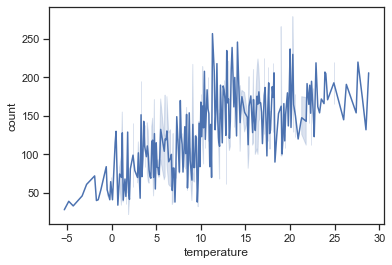

In [19]:
sns.lineplot(x='temperature',y='count',data=df_count)
# The hignest temperature of the year in Kaiserslautern is 28.8 ºC.

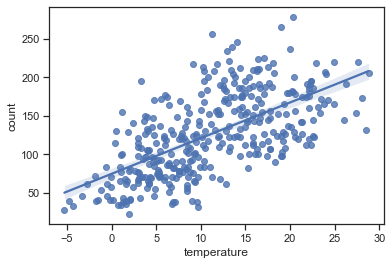

In [20]:
sns.regplot(x='temperature',y='count',data=df_count)

- Kaiserslautern has a suitable temperature all year round, and there is basically no extreme weather. Therefore, the bike rental amount is clearly distributed over the year.
- There is a significant positive correlation between the temperature and the rental situation of shared bikes. 
- The optimal temperature for trips is 11-15 ºC, in which the average rental is up to 250 times. Subsequently, there is no significant change with the increase of the temperature.
- The average rental amount reached the lowest when the temperature was near the lowest point of the year (-5 ºC).

### The effect of vapor pressure on rental amount

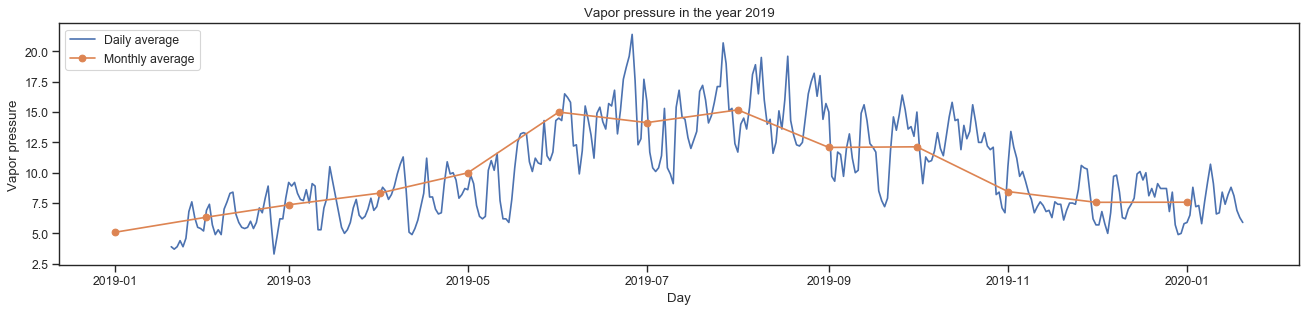

In [21]:
vaporpressuredf = df_count.groupby(['day'],as_index=False).agg({'vapor_pressure':'mean'})
vaporpressuredf['day'] = pd.to_datetime(vaporpressuredf['day'])

vaporpressuredf = vaporpressuredf.set_index('day')

vapor_month = df_count.groupby(['year','month'],as_index=False).agg({'weekday':'min','vapor_pressure':'mean'})
vapor_month.rename(columns={'weekday':'day'},inplace=True)
vapor_month['day'] = pd.to_datetime(vapor_month[['year','month','day']])

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)

plt.plot(vaporpressuredf.index,vaporpressuredf['vapor_pressure'],label='Daily average')
plt.plot(vapor_month['day'],vapor_month['vapor_pressure'],marker='o',label='Monthly average')
ax.set_xlabel('Day')
ax.set_ylabel('Vapor pressure')
plt.legend(loc="upper left")
ax.set_title('Vapor pressure in the year 2019')

plt.show()

# The figure below shows the trend of Kaiserslautern's vapor pressure during this period.

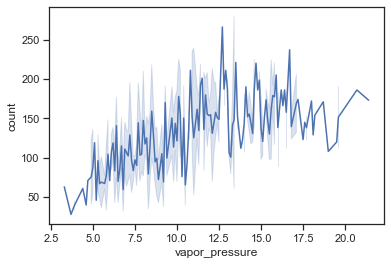

In [22]:
sns.lineplot(x='vapor_pressure',y='count',data=df_count)

- Vapor pressure is positively correlated with shared bike rental. The most suitable pressure for travel is 13 hpa and in which the rentals reach the peak of 260 times. 
- Subsequently, there was no obvious change trend with the increase of pressure. 
- The number of bike rental reaches the lowest when it is close to 3.5 hpa.

### The effect of humidity on rental amount

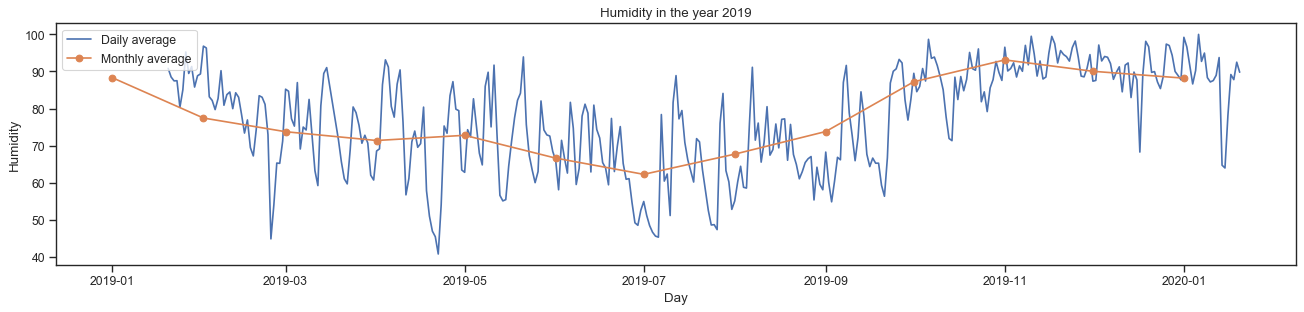

In [23]:
humiditydf = df_count.groupby(['day'],as_index=False).agg({'humidity':'mean'})
humiditydf['day'] = pd.to_datetime(humiditydf['day'])

humiditydf = humiditydf.set_index('day')

humidity_month = df_count.groupby(['year','month'],as_index=False).agg({'weekday':'min','humidity':'mean'})
humidity_month.rename(columns={'weekday':'day'},inplace=True)
humidity_month['day'] = pd.to_datetime(humidity_month[['year','month','day']])

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)

plt.plot(humiditydf.index,humiditydf['humidity'],label='Daily average')
plt.plot(humidity_month['day'],humidity_month['humidity'],marker='o',label='Monthly average')
ax.set_xlabel('Day')
ax.set_ylabel('Humidity')
plt.legend(loc="upper left")
ax.set_title('Humidity in the year 2019')

plt.show()

# The figure below shows the trend of Kaiserslautern's humidity during this period.

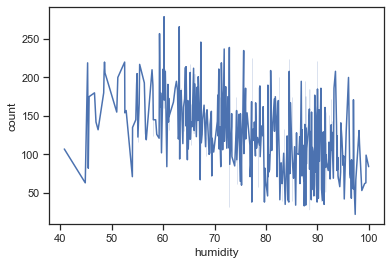

In [24]:
sns.lineplot(x='humidity',y='count',data=df_count)

- There is a negative correlation between wind speed and the amount of bike rental. 
- The optimum humidity is about 60%. At this humidity, users made the most trips by bike, reaching 280 times.
- When the humidity is around 40%-60%, the number of shared bike rentals does not change significantly and the rentals does not fluctuate greatly. However, when the humidity was over 60%, the rental count decreases significantly with the increase of humidity. 
- When the humidity is close to 98%, the number of Shared bike rental reaches the lowest.

### The effect of month on rental amount

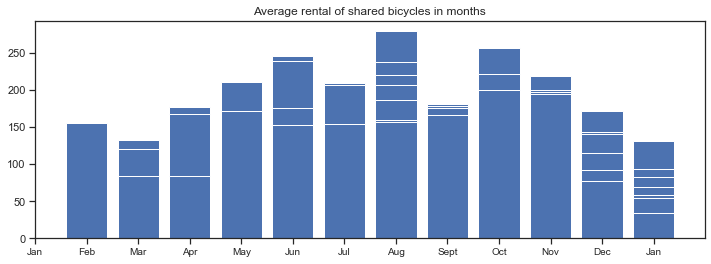

In [25]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
fig.set_size_inches(12,4)

plt.bar(df_count['month'], df_count['count'], align='center')
ax.set_title('Average rental of shared bicycles in months',fontsize=12)
ax.set_xticks(list(range(13)))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Jan'],fontsize=10)

plt.show()

- From March to August 2019, bike rental volumes continued to rise, despite an unusual low value in July. 
- The rental count in March 2019 was the lowest of the year (less than 150), and August saw a peak of 270. 
- After October, there was a significant downward trend, which was most likely due to a normal decline resulted from natural weather changes.

### The effect of weekend on rental amount

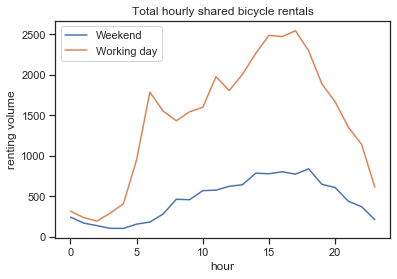

In [26]:
weekenddf1=df[df['is_weekend']==1].groupby("hour")['hour'].count()
weekenddf0=df[df['is_weekend']==0].groupby("hour")['hour'].count()

plt.plot(list(range(24)),weekenddf1, label="Weekend")
plt.plot(list(range(24)),weekenddf0, label="Working day")

plt.xlabel('hour')
plt.ylabel('renting volume')
plt.title('Total hourly shared bicycle rentals')
plt.legend(loc="upper left")

plt.show()

In [27]:
hourdf.fillna(0,inplace=True)

weekendhourdf1=hourdf[hourdf['is_weekend']==1].groupby('Date').mean()
weekendhourdf0=hourdf[hourdf['is_weekend']==0].groupby('Date').mean()

weekendhour1=np.mean(weekendhourdf1).reset_index(name='weekend')
weekendhour0=np.mean(weekendhourdf0).reset_index(name='working day')

isweekendhour = pd.merge(weekendhour1,
                         weekendhour0,
                         on='index',
                         how='outer')
isweekendhour = isweekendhour.drop([0,1])
isweekendhour = isweekendhour.reset_index(drop=True)
isweekendhour

,index,weekend,working day
0,0h,2.349515,1.211538
1,1h,1.631068,0.907692
2,2h,1.320388,0.742308
3,3h,1.000000,1.115385
4,4h,0.990291,1.565385
5,5h,1.504854,3.661538
6,6h,1.757282,6.873077
7,7h,2.718447,5.973077
8,8h,4.485437,5.511538
9,9h,4.436893,5.938462


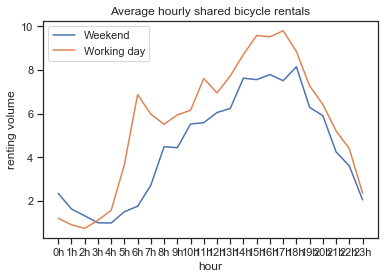

In [28]:
plt.plot(isweekendhour['index'], isweekendhour['weekend'], label='Weekend')
plt.plot(isweekendhour['index'], isweekendhour['working day'], label='Working day')

plt.xlabel('hour')
plt.ylabel('renting volume')
plt.title('Average hourly shared bicycle rentals')

plt.legend(loc="upper left")

plt.show()

- From the overall comparison of the two curves, the variation trend of average bike rental on weekdays and weekends is basically similar, despite small differences in numbers, which may be caused by the small commuter base in Kaiserslautern. 
- The overall active rental time on weekends lags working days by 2-3 hours.
- The average bike rental volume on weekdays and weekends peaks between 17:00 and 18:00 and reaches the lowest point st around 3am.

**On weekdays:**
- On weekdays, the average hourly total rental of bikes will reach two high points: at around 6am (averagely 7 rentals per hour) and 16pm-to-17pm (averagely 10 rentals per hour), which are exactly the peak rush hours.
  
**On non-working days:** 
- The commuting time of non-working days is mainly between 10:00-19:00, when the usage of shared bikes is relatively high. 
- On weekdays, during this period, the usage of bikes is relatively low. 
- The average bike rental volume of non-weekdays is significantly higher than that of weekdays from 0 to 3 am, which may be caused by late returns on weekends.

### The effect of holiday on rental amount

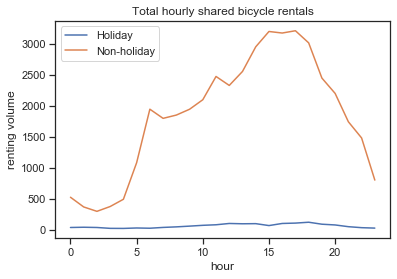

In [29]:
holidaydf1=df[df['is_holiday']==1].groupby("hour")['hour'].count()
holidaydf0=df[df['is_holiday']==0].groupby("hour")['hour'].count()

plt.plot(list(range(24)),holidaydf1, label="Holiday")
plt.plot(list(range(24)),holidaydf0, label="Non-holiday")

plt.xlabel('hour')
plt.ylabel('renting volume')
plt.title('Total hourly shared bicycle rentals')
plt.legend(loc="upper left")

plt.show()

In [30]:
holidayhourdf1=hourdf[hourdf['is_holiday']==1].groupby('Date').mean()
holidayhourdf0=hourdf[hourdf['is_holiday']==0].groupby('Date').mean()

holidayhour1=np.mean(holidayhourdf1).reset_index(name='holiday')
holidayhour0=np.mean(holidayhourdf0).reset_index(name='non-holiday')

isholidayhour = pd.merge(holidayhour1,
                         holidayhour0,
                         on='index',
                         how='outer')

isholidayhour = isholidayhour.drop([0,1])
isholidayhour = isholidayhour.reset_index(drop=True)

isholidayhour

,index,holiday,non-holiday
0,0h,2.266667,1.502874
1,1h,2.533333,1.051724
2,2h,2.266667,0.847701
3,3h,1.333333,1.071839
4,4h,1.266667,1.408046
5,5h,1.733333,3.106322
6,6h,1.466667,5.591954
7,7h,2.333333,5.166667
8,8h,2.933333,5.318966
9,9h,3.733333,5.589080


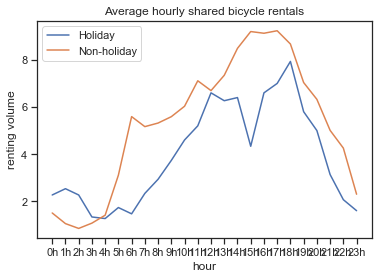

In [31]:
plt.plot(isholidayhour['index'], isholidayhour['holiday'], label='Holiday')
plt.plot(isholidayhour['index'], isholidayhour['non-holiday'], label='Non-holiday')

plt.xlabel('hour')
plt.ylabel('renting volume')
plt.title('Average hourly shared bicycle rentals')
plt.legend(loc="upper left")

plt.show()

- Holidays would include weekends if statutory holidays were next to the weekend holidays.
- The number of commuters during the holidays is mostly from 10:00 to 19:00, peaking at about 18:00 (8 orders per hour). However, a surprising low appears around 15 pm (only 4 orders/hour).
- The commuters on non-holidays mostly activated at 6:00-18:00, and the rental amount continued to peak at 15:00-18:00 (10 orders per hour).

### The effect of weekday on rental amount

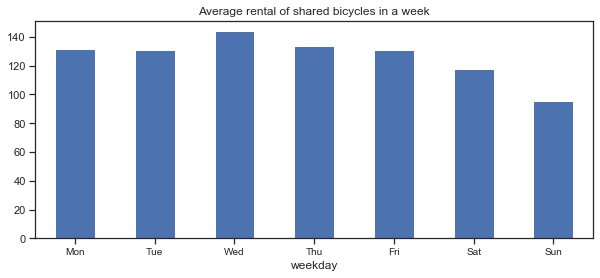

In [32]:
weekdaydf=df_count.groupby(['weekday'])['count'].mean()

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
fig.set_size_inches(10,4)

weekdaydf.plot(kind='bar',ax=ax)
ax.set_title('Average rental of shared bicycles in a week',fontsize=12)
ax.set_xticks(list(range(7)))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=10,rotation=0)

plt.show()

- There was little change in users' rental of bikes from Monday to Friday, and the number of bike rentals reduced significantly on Saturday and Sunday.
- The rental volume peaked on Wednesday at around 140.

### The effect of season on rental amount

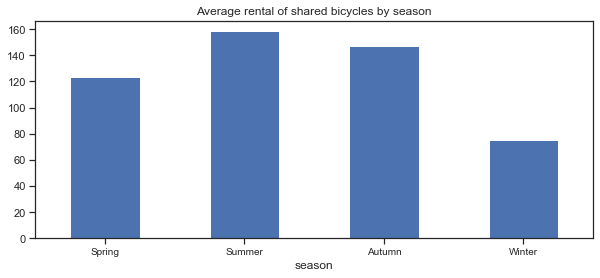

In [33]:
seasondf=df_count.groupby(['season'])['count'].mean()
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
fig.set_size_inches(10,4)

seasondf.plot(kind='bar',ax=ax)
ax.set_title('Average rental of shared bicycles by season',fontsize=12)
ax.set_xticks(list(range(4)))
ax.set_xticklabels(['Spring','Summer','Autumn','Winter'],fontsize=10,rotation=0)

plt.show()

The number of sharing-bike rentals in spring and winter is relatively small compared with the other two seasons. The number of rentals in winter was the lowest, less than half of that in summer.

### KPI Indicators for real-time monitoring

#### KPI 1: City Coverage & Bike Activity Scope

In [34]:
from math import cos, sin, atan2, sqrt, pi ,radians, degrees

def center_geolocation(geolocations):        
    x = 0    
    y = 0    
    z = 0    
    lenth = len(geolocations)    
    for lon, lat in geolocations:        
        lon = radians(float(lon))        
        lat = radians(float(lat))              
        
        x += cos(lat) * cos(lon)        
        y += cos(lat) * sin(lon)        
        z += sin(lat)     
        
        x = float(x / lenth)   
        y = float(y / lenth)   
        z = float(z / lenth)     
        
        return (degrees(atan2(y, x)), degrees(atan2(z, sqrt(x * x + y * y))))

In [35]:
locationdestdf = pd.DataFrame({'lat':df['dest_lat'],
                           'lng':df['dest_lng']})
locationdestdf = locationdestdf.values.tolist()

print("Bike Activity Scope Center: ",center_geolocation(locationdestdf))


def geodistance(lat1,lng1,lat2,lng2):
    
    lat1, lng1, lat2, lngt2 = map(radians, [float(lat1), float(lng1), float(lat2), float(lng2)])
    dlat=lat2-lat1
    dlng=lng2-lng1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2 
    distance=2 * sin(sqrt(a)) * 6371 * 1000 
    distance=round(distance/1000,3)
    return distance

print('The coverage radius of the bikes is:',geodistance(df['dest_lat'].mean(), df['dest_lng'].mean(), 49.49894614, 8.46722424),'m')

Bike Activity Scope Center:  (49.43651863, 7.769023775999999)
The coverage radius of the bikes is: 6716.589 m


#### KPI 2: Bike Utilization Rate

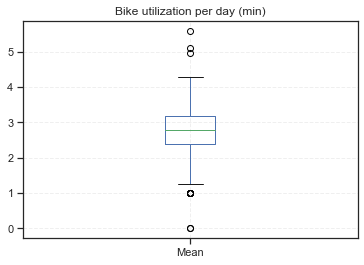

count    273.000000
mean       2.722601
std        0.722686
min        0.000000
25%        2.380000
50%        2.780000
75%        3.170000
max        5.590000
Name: Mean, dtype: float64

In [36]:
bike_utilization.fillna(0,inplace=True)

bikeutidf = bike_utilization['Mean']
bikeutidf.plot.box(title="Bike utilization per day (min)")
plt.grid(linestyle="--", alpha=0.3)

plt.show()
bikeutidf.describe()

# Total minutes that a bike was being occupied in a year / Total number of days

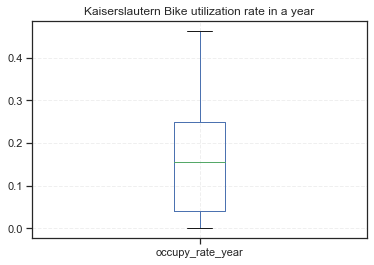

count    273.000000
mean       0.157842
std        0.119795
min        0.000000
25%        0.041322
50%        0.154270
75%        0.247934
max        0.462810
Name: occupy_rate_year, dtype: float64

In [37]:
bikeutiratedf = bike_utilization['occupy_rate_year']
bikeutiratedf.plot.box(title="Kaiserslautern Bike utilization rate in a year")
plt.grid(linestyle="--", alpha=0.3)

plt.show()
bikeutiratedf.describe()

# Total days that a bike was being occupied in a year / Total number of days

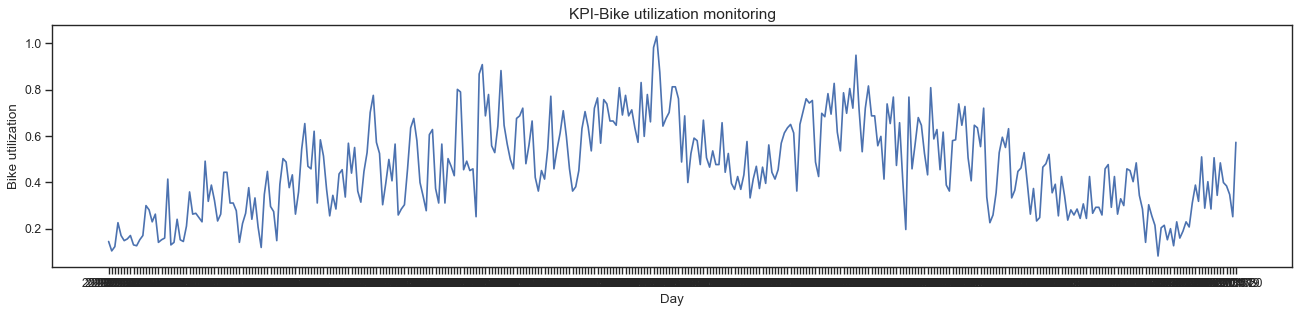

In [38]:
kpiutilization = bike_utilization.iloc[272]
kpiutilization = kpiutilization.to_frame()
kpiutilization.drop(['index','b_number','Grand Total','Mean','occupy_day','occupy_rate_year'],inplace=True)

fig,ax = plt.subplots(figsize=(20,4), dpi= 80)
ax.plot(kpiutilization)
plt.xlabel('Day')
plt.ylabel('Bike utilization')
plt.title('KPI-Bike utilization monitoring',fontsize=14)

plt.show()

# The daily curve of shared bike utilization, which can be used for real-time monitoring.

#### KPI 3: Daily Operating Revenue

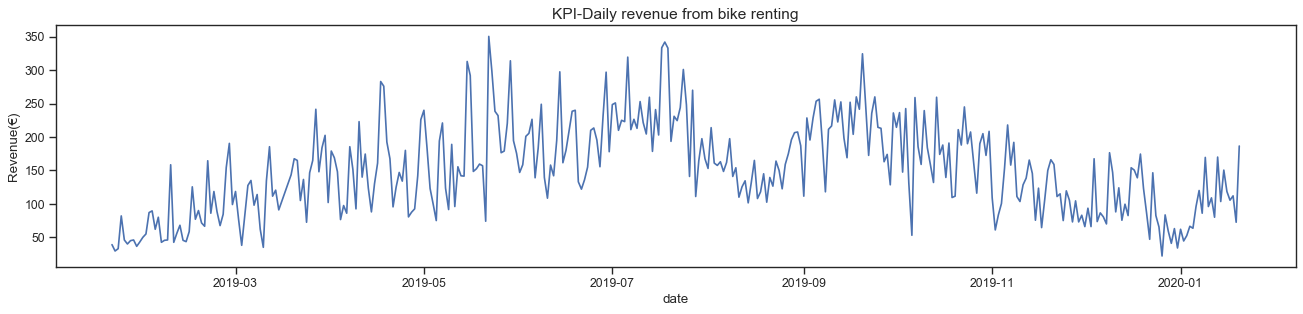

In [39]:
fig,ax = plt.subplots(figsize=(20,4),dpi=80)

ax = sns.lineplot(x='day', y='price',data=df_count)
 
plt.title('KPI-Daily revenue from bike renting',fontsize=14)
plt.xlabel('date')
plt.ylabel('Revenue(€)')
 
plt.show()

### Predictive analysis

After understanding the basic relationship between variables through the above data, the following starts to monitor, model and predict the data in real-time basis.

#### 1. Linear regression - OLS

In [40]:
reg1=smf.ols('count~temperature',data=df_count).fit()
print(reg1.summary())
# p-value=0, which means the effect of temperature feature is significant. However that R2 model fit is not enough (0.397).

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     237.2
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           1.70e-41
Time:                        13:31:09   Log-Likelihood:                -1862.0
No. Observations:                 363   AIC:                             3728.
Df Residuals:                     361   BIC:                             3736.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      74.7644      3.969     18.839      

In [41]:
reg2=smf.ols('count~temperature+vapor_pressure+month+is_weekend',data=df_count).fit()
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     92.18
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           8.35e-54
Time:                        13:31:09   Log-Likelihood:                -1825.2
No. Observations:                 363   AIC:                             3660.
Df Residuals:                     358   BIC:                             3680.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         93.9246      6.894     13.

In [42]:
# Randomly select 30% of the data to construct test samples, and the rest as training samples.

X = np.array(df_count['temperature']).reshape(-1,1)
y = np.array(df_count['count']).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=60, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_y_pred = lr.predict(X_test)

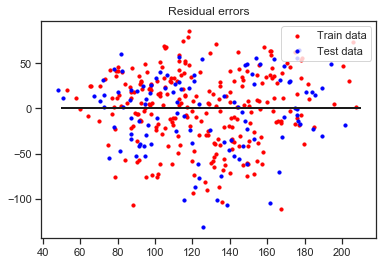

In [43]:
# plotting residual errors in training data
plt.scatter(lr.predict(X_train), lr.predict(X_train) - y_train, color = 'red', s = 10, label = 'Train data') 

# plotting residual errors in test data 
plt.scatter(lr.predict(X_test), lr.predict(X_test) - y_test, color = 'blue', s = 10, label = 'Test data') 

## plotting line for zero residual error 
plt.hlines(y = 0, xmin = 50, xmax = 210, linewidth = 2) 

plt.legend(loc = 'upper right') 
plt.title("Residual errors") 
plt.show() 

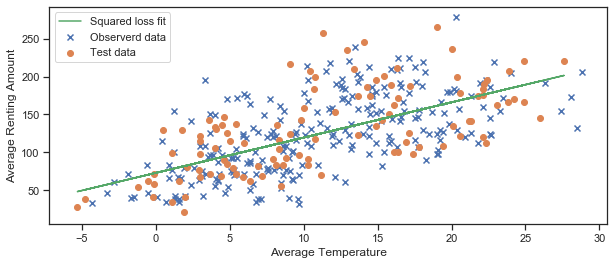

In [44]:
plt.figure(figsize = (10,4))

plt.scatter(X_train, y_train, marker='x', label='Observerd data')
plt.scatter(X_test,y_test,marker='o',label='Test data')
plt.xlabel('Average Temperature')
plt.ylabel('Average Renting Amount')

plt.plot(X_test, lr_y_pred, c='C2',label='Squared loss fit')

plt.legend()
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler

# Analyze some features of the regression target value and observe the fluctuation range of the rental volume. 
# If the difference is too large, it needs to be standardized.

ss_X=StandardScaler()   
ss_y=StandardScaler()

X_train=ss_X.fit_transform(X_train)
X_test=ss_X.transform(X_test)
y_train=ss_y.fit_transform(y_train.reshape(-1, 1))
y_test=ss_y.transform(y_test.reshape(-1, 1))

lr.fit(X_train,y_train)
lr_y_pred=lr.predict(X_test)

print("The value of default measurement of LinearRegression is",lr.score(X_test,y_test))
print("The value of R_suqared of LinearRegression is",r2_score(y_test,lr_y_pred))
print("The mean squared error of LinearRegression is",
      mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(lr_y_pred)))   
#inverse_transform is used to restore real results.

print("The mean absolute error of LinearRegression is",
      mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(lr_y_pred)))

The value of default measurement of LinearRegression is 0.4154089586536439
The value of R_suqared of LinearRegression is 0.4154089586536439
The mean squared error of LinearRegression is 1786.6288036531462
The mean absolute error of LinearRegression is 34.00109959276684


#### 2. Linear regression - SGD

In [46]:
sgdr=SGDRegressor()
sgdr.fit(X_train,y_train)
sgdr_y_pred=sgdr.predict(X_test)

print("The value of default measurement of SGDRegressor is",sgdr.score(X_test,y_test))
print("The value of R_suqared of SGDRegression is",r2_score(y_test,sgdr_y_pred))
print("The mean squared error of SGDRegression is",
      mean_squared_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(sgdr_y_pred)))
print("The mean absolute error of SGDRegression is",
      mean_absolute_error(ss_y.inverse_transform(y_test),ss_y.inverse_transform(sgdr_y_pred)))

The value of default measurement of SGDRegressor is 0.4153021904990424
The value of R_suqared of SGDRegression is 0.4153021904990424
The mean squared error of SGDRegression is 1786.9551087909829
The mean absolute error of SGDRegression is 34.03401157597713


D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


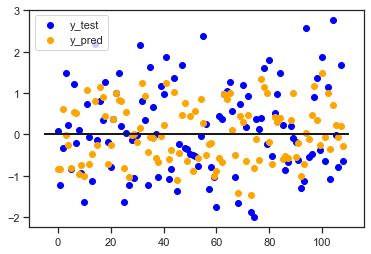

In [47]:
plt.scatter(np.arange(len(y_test)),y_test,color = 'blue',label='y_test')
plt.scatter(np.arange(len(sgdr_y_pred)),sgdr_y_pred,color = 'orange',label='y_pred')
plt.hlines(y = 0, xmin = -5, xmax = 110, linewidth = 2) 
plt.legend(loc=2)
plt.show()

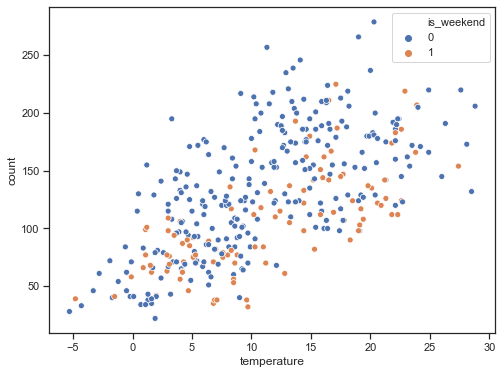

In [48]:
plt.figure(figsize = (8,6))

sns.scatterplot(x=df_count['temperature'], y=df_count['count'], hue=df_count['is_weekend'])
plt.show()

In [49]:
X = df_count[['temperature', 'is_weekend']]
y = df_count['count'].values.reshape(-1,1)
mlr = LinearRegression()
mlr.fit(X,y)
print(mlr.coef_, mlr.intercept_)

[[  4.68101316 -29.50401928]] [82.63954753]


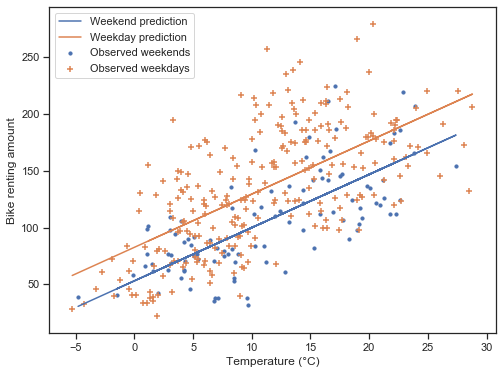

In [50]:
X_weekend = X[X['is_weekend']==1]
X_weekday = X[X['is_weekend']==0]

# predict weekends and weekdays seperately
y_pred_weekend = mlr.predict(X_weekend)
y_pred_weekday = mlr.predict(X_weekday)

plt.figure(figsize = (8,6))

plt.scatter(X_weekend['temperature'], df_count[df_count['is_weekend']==True]['count'], 
            marker='o',s=10,label='Observed weekends')

plt.scatter(X_weekday['temperature'], df_count[df_count['is_weekend']==False]['count'], 
            marker='+',label='Observed weekdays')

plt.plot(X_weekend['temperature'], y_pred_weekend, label='Weekend prediction')
plt.plot(X_weekday['temperature'], y_pred_weekday, label="Weekday prediction")

plt.xlabel('Temperature (°C)')
plt.ylabel('Bike renting amount')

plt.legend()
plt.show()

In [51]:
# 1v means one variance
y = df_count['count']
X_1v = df_count['temperature'].values.reshape((-1,1))
X_2v = df_count[['temperature', 'is_weekend']]

# make predictions
mlr1v = LinearRegression()
mlr2v = LinearRegression()
mlr1v.fit(X_1v,y)
mlr2v.fit(X_2v,y)

y_pred_1v = mlr1v.predict(X_1v)
y_pred_2v = mlr2v.predict(X_2v)

print('The main absolute error of MLR-weekend:', mean_absolute_error(y,y_pred_1v))
print('The main absolute error of MLR-weekday:', mean_absolute_error(y,y_pred_2v))

print('The main squared error of MLR-weekend:', mean_squared_error(y,y_pred_1v)**0.5)
print('The main squared error of MLR-weekday:', mean_squared_error(y,y_pred_2v)**0.5)

print('The value of R_suqared of MLR-weekend:', r2_score(y,y_pred_1v))
print('The value of R_suqared of MLR-weekday:', r2_score(y,y_pred_2v))

The main absolute error of MLR-weekend: 33.2498778319548
The main absolute error of MLR-weekday: 31.321144847871203
The main squared error of MLR-weekend: 40.880532528758785
The main squared error of MLR-weekday: 38.65756816696334
The value of R_suqared of MLR-weekend: 0.3965242351478998
The value of R_suqared of MLR-weekday: 0.4603703480058734


#### 3. Decision tree regression

In [52]:
y = df_count['count'].values
X = df_count.drop(['count','price','day','city'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("X_train_shape:", X_train.shape, " y_train_shape:", y_train.shape)
print("X_test_shape:", X_test.shape,"  y_test_shape:", y_test.shape)

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
print("train score:", tree.score(X_train, y_train))
print("test score:", tree.score(X_test, y_test))

X_train_shape: (254, 10)  y_train_shape: (254,)
X_test_shape: (109, 10)   y_test_shape: (109,)
train score: 1.0
test score: 0.2031718487924422


In [53]:
def cv_score(d):
    tree = DecisionTreeRegressor(max_depth=d)
    tree.fit(X_train, y_train)
    return(tree.score(X_train, y_train), tree.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
depths = np.arange(1,10)
scores = [cv_score(d) for d in depths]
tr_scores = [s[0] for s in scores]
te_scores = [s[1] for s in scores]

# Find out the index with the highest score in the Cross-validation dataset
tr_best_index = np.argmax(tr_scores)
te_best_index = np.argmax(te_scores)

print("bestdepth:", te_best_index+1, " bestdepth_score:", te_scores[te_best_index], '\n')

bestdepth: 4  bestdepth_score: 0.5779760801306355 



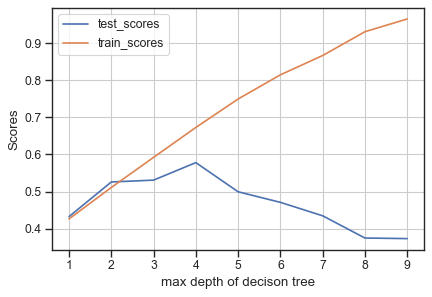

In [54]:
depths = np.arange(1,10)
plt.figure(figsize=(6,4), dpi=80)
plt.grid()
plt.xlabel('max depth of decison tree')
plt.ylabel('Scores')
plt.plot(depths, te_scores, label='test_scores')
plt.plot(depths, tr_scores, label='train_scores')
plt.legend()

In [55]:
rf_regressor = ensemble.RandomForestRegressor(max_depth=te_best_index+1, n_estimators=100)
rf_regressor.fit(X_train, y_train)

importance = rf_regressor.feature_importances_
y_test_pred = rf_regressor.predict(X_test)
print(metrics.r2_score(y_test, y_test_pred))

0.6644451209027332


[6 2 7 8 1 5 3 9 4 0]


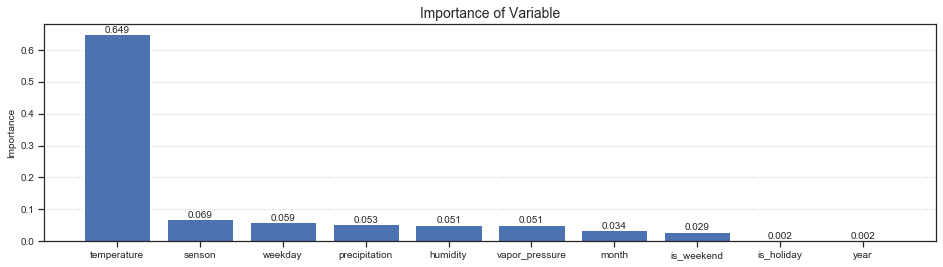

In [56]:
df_count_features = df_count.drop(['count','price','day','city'],axis=1)

fig=plt.figure()
fig.set_size_inches(16,4)

plt.subplot(1,1,1)
plt.title('Importance of Variable', fontsize=14)
plt.ylabel('Importance', fontsize=10)
plt.tick_params(labelsize=10)
plt.grid(axis='y', linestyle=':')
sorted_indices = importance.argsort()[::-1]
print(sorted_indices)
pos = np.arange(sorted_indices.size)
plt.bar(pos, importance[sorted_indices])
plt.xticks(range(10),('temperature','senson','weekday','precipitation','humidity',
                      'vapor_pressure','month','is_weekend','is_holiday','year'))
for a,b in zip(pos,importance[sorted_indices]):
    plt.text(a, b, '%.3f' % b, ha='center', va= 'bottom',fontsize=10)

plt.show()

In [57]:
df_lr_data = df_count.loc[:,['temperature','season','weekday','precipitation','vapor_pressure']]
df_lr_target = df_count.loc[:,['count']]
x = df_lr_data.values
y = df_lr_target.values

In [58]:
x,y = make_blobs(n_samples=300, n_features=2, centers=6)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, train_size=0.7)

clf1 = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
clf2 = RandomForestClassifier(n_estimators=10,max_features=math.sqrt(2), max_depth=None,min_samples_split=2, bootstrap=True)
clf3 = ExtraTreesClassifier(n_estimators=10,max_features=math.sqrt(2), max_depth=None,min_samples_split=2, bootstrap=False)

scores1 = cross_val_score(clf1, x_train, y_train)
scores2 = cross_val_score(clf2, x_train, y_train)
scores3 = cross_val_score(clf3, x_train, y_train)

print('DecisionTreeClassifier cross-validation accuracy:'+str(scores1.mean()))    
print('RandomForestClassifier cross-validation accuracy:'+str(scores2.mean()))    
print('ExtraTreesClassifier cross-validation accuracy:'+str(scores3.mean()))

DecisionTreeClassifier cross-validation accuracy:0.9761904761904763
RandomForestClassifier cross-validation accuracy:0.9904761904761905
ExtraTreesClassifier cross-validation accuracy:1.0


In [59]:
clf1.fit(x_train, y_train)
clf2.fit(x_train, y_train)
clf3.fit(x_train, y_train)

x1_min, x1_max = x[:, 0].min(), x[:, 0].max()            # range of column 0
x2_min, x2_max = x[:, 1].min(), x[:, 1].max()            # range of column 1
x1, x2 = np.mgrid[x1_min:x1_max:200j, x2_min:x2_max:200j]# generate grid sampling points: both rows and columns are 200
area_smaple_point = np.stack((x1.flat, x2.flat), axis=1) # divide the area into a series of test points and predict, then draw the area based on the prediction result
area1_predict = clf1.predict(area_smaple_point)          # predict all points
area1_predict = area1_predict.reshape(x1.shape) 


area2_predict = clf2.predict(area_smaple_point)          
area2_predict = area2_predict.reshape(x1.shape)

area3_predict = clf3.predict(area_smaple_point)          
area3_predict = area3_predict.reshape(x1.shape)
  
mpl.rcParams['axes.unicode_minus'] = False               # used to display negative signs normally

classifier_area_color = mpl.colors.ListedColormap(['#A0FFA0', '#FFA0A0', '#A0A0FF'])  # area color
cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])                                  # color of sample category

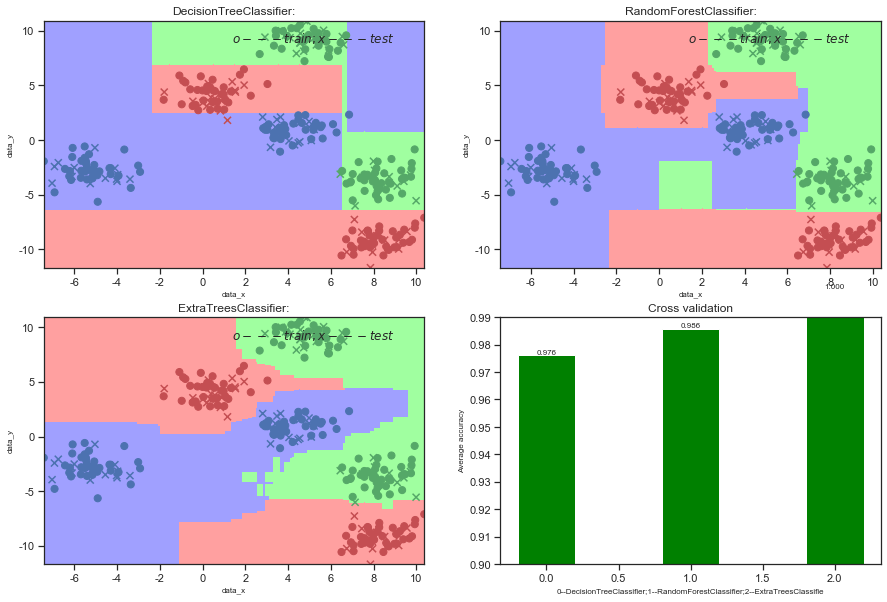

In [60]:
fig=plt.figure()
fig.set_size_inches(15,10)

plt.subplot(2,2,1) 
plt.pcolormesh(x1, x2, area1_predict, cmap=classifier_area_color)                        
plt.scatter(x_train[:,0], x_train[:,1], c=y_train,marker='o', s=50, cmap=cm_dark)    
plt.scatter(x_test[:,0],x_test[:,1], c=y_test,marker='x', s=50, cmap=cm_dark) 
plt.xlabel('data_x', fontsize=8)  
plt.ylabel('data_y', fontsize=8)
plt.xlim(x1_min, x1_max)  
plt.ylim(x2_min, x2_max)
plt.title(u'DecisionTreeClassifier:', fontsize=12)
plt.text(x1_max-9, x2_max-2, u'$o---train ; x---test$')

plt.subplot(2,2,2) 
plt.pcolormesh(x1, x2, area2_predict, cmap=classifier_area_color)                        
plt.scatter(x_train[:,0], x_train[:,1], c=y_train,marker='o', s=50, cmap=cm_dark)    
plt.scatter(x_test[:,0],x_test[:,1], c=y_test,marker='x', s=50, cmap=cm_dark) 
plt.xlabel('data_x', fontsize=8)  
plt.ylabel('data_y', fontsize=8)
plt.xlim(x1_min, x1_max)  
plt.ylim(x2_min, x2_max)
plt.title(u'RandomForestClassifier:', fontsize=12)
plt.text(x1_max-9,x2_max-2, u'$o---train ; x---test$')

plt.subplot(2,2,3) 
plt.pcolormesh(x1, x2, area3_predict, cmap=classifier_area_color)                        
plt.scatter(x_train[:,0], x_train[:,1], c=y_train,marker='o', s=50, cmap=cm_dark)    
plt.scatter(x_test[:,0],x_test[:,1], c=y_test,marker='x', s=50, cmap=cm_dark) 
plt.xlabel('data_x', fontsize=8)  
plt.ylabel('data_y', fontsize=8)
plt.xlim(x1_min, x1_max)  
plt.ylim(x2_min, x2_max)
plt.title(u'ExtraTreesClassifier:', fontsize=12)
plt.text(x1_max-9, x2_max-2, u'$o---train ; x---test$') 

plt.subplot(2,2,4)
y=[]
scores1 = cross_val_score(clf1, x_train, y_train)
y.append(scores1.mean())
scores2 = cross_val_score(clf2, x_train, y_train)
y.append(scores2.mean())
scores3 = cross_val_score(clf3, x_train, y_train)
y.append(scores3.mean())

x=[0,1,2]
plt.bar(x,y,0.4,color="green")  
plt.xlabel("0--DecisionTreeClassifier;1--RandomForestClassifier;2--ExtraTreesClassifie", fontsize=8)  
plt.ylabel("Average accuracy", fontsize=8)
plt.ylim(0.9, 0.99)
plt.title("Cross validation",fontsize=12)
for a, b in zip(x, y):      
    plt.text(a, b,'%.3f'% b, ha='center', va='bottom', fontsize=8) 

plt.show()

#### 4. Lasso regression

In [61]:
X = df_count[['month','weekday','is_weekend','temperature','precipitation','humidity','vapor_pressure']]
Y = df_count[['count']]
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=42,train_size=0.7)

lasso = Lasso().fit(X_train,y_train)
lasso001 = Lasso(alpha=0.01).fit(X_train,y_train)
lasso00001 = Lasso(alpha=0.0001).fit(X_train,y_train)

In [62]:
print("Lasso alpha=1")
print ("training set score:{:.2f}".format(lasso.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso.coef_!=0)))

print('**********************************')
print("Lasso alpha=0.01")
print ("training set score:{:.2f}".format(lasso001.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso00001.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso001.coef_!=0)))

print('**********************************')
print("Lasso alpha=0.0001")
print ("training set score:{:.2f}".format(lasso00001.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso00001.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso00001.coef_!=0)))

Lasso alpha=1
training set score:0.53
test set score:0.47
Number of features used:7
**********************************
Lasso alpha=0.01
training set score:0.54
test set score:0.48
Number of features used:7
**********************************
Lasso alpha=0.0001
training set score:0.54
test set score:0.48
Number of features used:7


In [63]:
predict = lasso.predict(X_train)
print('Coefficients: ', lasso.coef_, '\nIntercept: ', lasso.intercept_ )

Coefficients:  [  3.2069602   -3.68762451 -14.40755876   6.42694347  -2.26046873
   0.28523549  -4.03820986] 
Intercept:  [80.22893136]


36.45141725692738

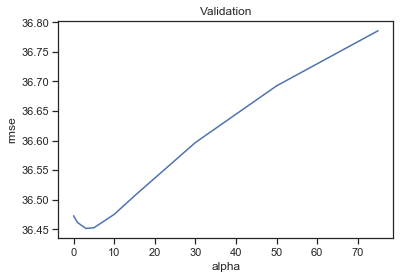

In [64]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, 
                                   scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# Pick the best alpha through the Lasso model
alphas = [0.0001, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]  

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min() 

In [65]:
# View Lasso regression coefficients

model_lasso = Lasso(alpha=3).fit(X_train,y_train)
coef = pd.Series(model_lasso.coef_, index = X_train.columns)   
  
print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  
      str(sum(coef == 0)) + " variables")

coef

Lasso picked 5 variables and eliminated the other 2 variables


month             3.234890
weekday          -5.798555
is_weekend       -0.000000
temperature       3.673615
precipitation    -1.951975
humidity         -0.368041
vapor_pressure   -0.000000
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

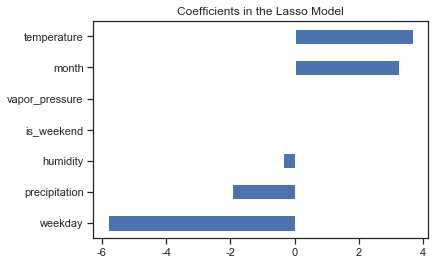

In [66]:
# Visualize Lasso regression coefficients

imp_coef = pd.concat([coef.sort_values()])
mpl.rcParams['figure.figsize'] = (6,4)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


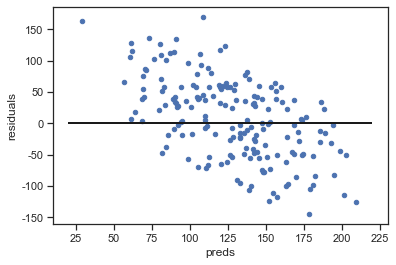

In [67]:
# View the difference between the predicted value and the true value
# Look at the residuals as well

mpl.rcParams['figure.figsize'] = (6,4)

preds = pd.DataFrame({'preds':model_lasso.predict(X_train)})
preds['true'] = y_train
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals',kind = 'scatter')
plt.hlines(y = 0, xmin = 20, xmax = 220, linewidth = 2) 